Tendo feito o tratamento e análise dos dados, agora podemos construir modelos de classificação que serão úteis para o Alura Voz, entre os modelos que podemos criar estão o SVC, Decision Tree e Random Forest.

### Importando bibliotecas

Para a aplicação utilizaremos `pandas`, `seaborn`, `sklearn`, `imblearn` e `sys`. Para saber mais sobre as bibliotecas sklearn e imblearn, acesse a documentação:
- [Scikit Learn](https://scikit-learn.org/stable/); e
- [Imbalanced Learn](https://imbalanced-learn.org/stable/).

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import seaborn as sns

from utils.utils import plot_countplot, plot_matriz_confusao, compara_modelos_metricas
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="darkgrid")
SEED = 42

### Aplicando encoder

É feita a leitura do banco de dados com o método `read_json` do pandas.

In [3]:
dados = pd.read_json("../Dados/Telco-Customer-Churn-limpeza.json")
dados.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


Agora, é preciso remover algumas colunas que não são tão importantes para a análise que desejamos realizar. O método que permite remover colunas é o `drop()` da biblioteca pandas.

Existem duas colunas que não são interessantes para a análise e que serão removidas:

* Coluna `custumerID`: Seu valor é único para cada linha e não nos traz informação relevante para uma análise, então podemos retirá-la; e
* Coluna `Charges.Total`: essa coluna contém informações dos meses de `Charges.Monthly` multiplicado por `tenure`, então é uma informação "duplicada".

In [4]:
dados.drop(['customerID', 'Charges.Total'], axis=1, inplace=True)

Vamos imprimir as classes de cada coluna que seja do tipo categórica para entender quais tratamentos e onde podem ser realizados.

In [5]:
for i in dados.select_dtypes(include=['object']).columns:
    if len(dados[i].unique()) > 2:
       print(f"{i}: {dados[i].unique()}")

MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['Yes' 'No' 'No internet service']
StreamingTV: ['Yes' 'No' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['One year' 'Month-to-month' 'Two year']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


É possível notar que algumas colunas tem a classe `No phone service` e `No internet service` que equivale a classe `No`, ou seja, não existe serviço. Para essas classes, vamos considerá-las como `No` para evitar uma informação duplicada. Como terão apenas dois resultados `Yes` e `No` (`Sim` e `Não`), substituiremos por um número binário, 1 e 0.

Além disso, as colunas 'PaymentMethod', 'Contract' e 'InternetService' possuem mais de 2 categorias e por conta disso, faremos encoding para os dados dessas colunas.

In [6]:
colunas = ['PaymentMethod', 'Contract', 'InternetService']
dados2 = dados.drop(colunas, axis=1)
dados2.columns

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'Charges.Monthly'],
      dtype='object')

In [7]:
dicionario = {'No internet service':0,
              'No phone service': 0,
              'No': 0,
              'Yes': 1,
              'Male':0,
              'Female':1}

In [8]:
dados2 = dados2.replace(dicionario)
dados2.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Charges.Monthly
0,0,1,0,1,1,9,1,0,0,1,0,1,1,0,1,65.6
1,0,0,0,0,0,9,1,1,0,0,0,0,0,1,0,59.9
2,1,0,0,0,0,4,1,0,0,0,1,0,0,0,1,73.9
3,1,0,1,1,0,13,1,0,0,1,1,0,1,1,1,98.0
4,1,1,1,1,0,3,1,0,0,0,0,1,1,0,1,83.9


Existem várias formas de criar encoding, duas delas são o Label Encoding e o One-Hot Encoding.

#### Tipos de encoding

* `Label Encoding` - Renomea as classes com valores numéricos de 1 a n, sendo n o número de classes. Pode existir hierarquia entre as classes.

* `One-Hot Encoding`  - Transforma as variáveis em n colunas binárias, sendo n o número de classes. Todas as classes são analisadas de forma igual, quando tiver a ocorrência dela a coluna terá o valor 1 e quando não o valor 0, isso acontece para as demais colunas criadas.

No nosso caso, vamos optar pelo método que transforma as variáveis em colunas binárias. Para saber mais sobre esse método consulte a documentação.

- [OneHotEncoder documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

É possível também preparar essa forma de encoding com [`get_dummies` do pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), se quiser saber mais sobre esse método e o primeiro, recomendamos a leitura do artigo [Pandas Get Dummies (One-Hot Encoding) – pd.get_dummies()](https://amiradata.com/pandas-get-dummies/).

Fique a vontade para testar as duas maneiras.

In [9]:
ohe = OneHotEncoder(dtype=int)

colunas_ohe = ohe.fit_transform(dados[colunas]).toarray()
dados3 = pd.concat([dados2, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names(colunas))], axis=1)
dados3

C:\Users\Sthefanie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,0,1,0,1,1,9,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
1,0,0,0,0,0,9,1,1,0,0,...,0,0,0,1,1,0,0,1,0,0
2,1,0,0,0,0,4,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,1,1,1,1,0,3,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,0,0,0,13,1,0,1,0,...,0,0,0,1,0,1,0,1,0,0
7039,1,0,0,1,0,22,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
7040,0,0,0,0,0,2,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
7041,0,0,0,1,1,67,1,0,1,0,...,0,0,0,1,0,0,1,1,0,0


Agora, temos dados apenas com valores numéricos.

## Balanceamento dos dados

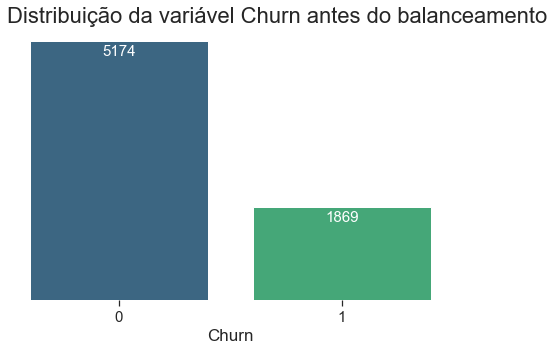

In [10]:
plot_countplot(dados=dados3, 
               x='Churn', 
               titulo="Distribuição da variável Churn antes do balanceamento",
               label_x='Churn'
    )

Percebemos pelo gráfico acima que o conjunto de dados possui o **alvo** (coluna `'Churn'`) [desbalanceado](https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados?utm_source=gnarus&utm_medium=timeline), caso o modelo seja criado com a variável dessa forma poderá prejudicar o aprendizados e os resultados.

Para evitar problemas no aprendizado do modelo, vamos realizar o balanceamento com o método [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) da biblioteca imblearn.

In [11]:
X = dados3.drop(['Churn'], axis = 1)
y = dados3['Churn']

In [12]:
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X, y)

In [13]:
dados4 = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)

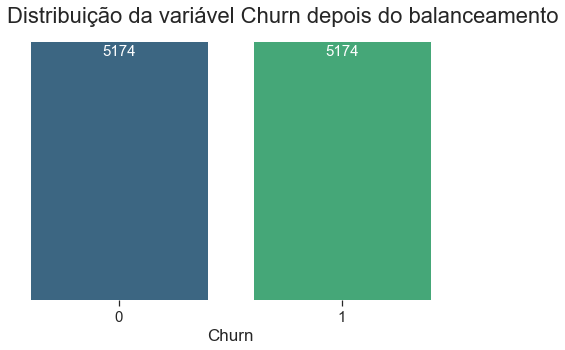

In [14]:
plot_countplot(dados=dados4, 
               x='Churn', 
               titulo="Distribuição da variável Churn depois do balanceamento",
               label_x='Churn'
    )

Agora, `dados4` estão com os valores da coluna **alvo** com as mesmas quantidades, ou seja, estão balanceados. Portanto, utilizaremos `dados4` para construção dos modelos de classificação.

In [15]:
dados4.to_json("../Dados/Telco-Customer-Churn-balanceamento.json")

## Criando os modelos

Para iniciar o treinamento, separamentos os dados em **treino** e **teste**.

In [16]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_res , y_res, random_state=SEED)

### 1. SVC

O primeiro modelo a ser montado é o classificador **SVC**, para montá-lo utilizamos o método [SVC da biblioteca sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Para saber mais sobre esse método você pode acessar o vídeo [Estimadores não lineares e support vector machine  do curso Machine Learning: introdução a classificação com SKLearn](https://cursos.alura.com.br/course/machine-learning-introducao-a-classificacao-com-sklearn/task/46782).

In [17]:
svc = SVC(random_state=SEED)
svc.fit(X_treino, y_treino)
y_pred_svc = svc.predict(X_teste)

Após treinado o modelo, precisamos saber quão bem ele foi em seu treinamento, para isso coletamos as classificações a partir de um conjunto de dados desconhecido pelo modelo, o conjunto de teste.

As respostas da avaliação de cada item do conjunto de teste realizada pelo modelo podem ser verificadas para sabermos quão bem ele foi em seu teste. A avaliação consiste na análise de várias métricas que informam o sucesso do modelo. As métricas que iremos avaliar serão [**Acurácia**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92910), [**Precisão, Recall e F1 Score**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92914) e a [**Matriz de Confusão**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92912)

Essas métricas nós obtemos pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

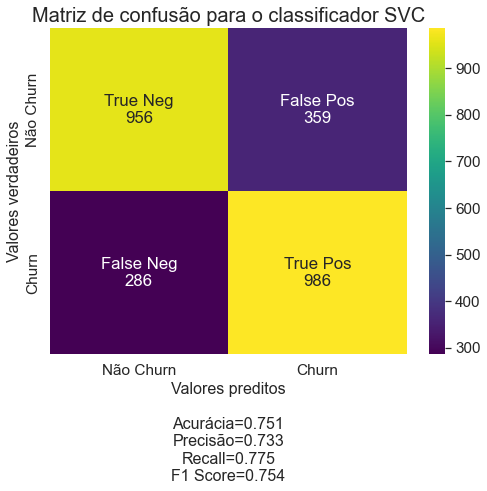

In [18]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_svc,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador SVC"
            )

### 2. Decision Tree

O segundo modelo a ser montado é o classificador **Decision Tree**, para montá-lo utilizamos o método [Decision Tree da biblioteca sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

E para saber mais sobre esse método você pode acessar o vídeo [Árvores de Decisão: aprofundando em modelos de Machine Learning](https://cursos.alura.com.br/course/arvores-decisao-aprofundando-modelos-machine-learning).

Depois do treinado o modelo, testamos ele e plotamos a matriz de confusão e outras métricas, pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

In [19]:
dtree = DecisionTreeClassifier(max_depth=5, random_state = SEED)
dtree.fit(X_treino, y_treino)
y_pred_dt = dtree.predict(X_teste)

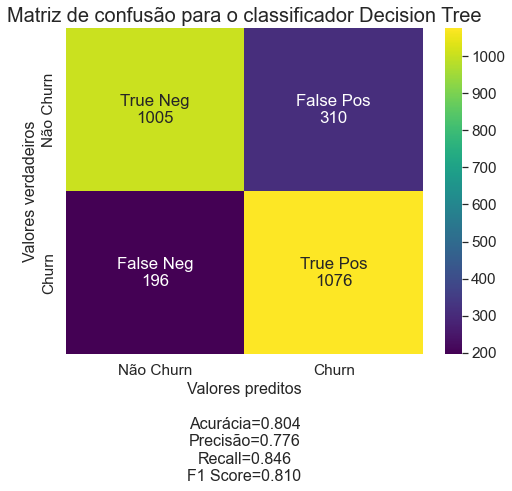

In [20]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_dt,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador Decision Tree")

### 3. Random Forest

O segundo modelo a ser montado é o classificador **Decision Tree**, para montá-lo utilizamos o método [Random Forest da biblioteca sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

E para saber mais sobre esse método você pode acessar o vídeo [Árvores de Decisão: aprofundando em modelos de Machine Learning](https://cursos.alura.com.br/course/arvores-decisao-aprofundando-modelos-machine-learning).

Depois do treinado o modelo, testamos ele e plotamos a matriz de confusão e outras métricas, pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

In [21]:
rforest = RandomForestClassifier(max_depth = 5, random_state=SEED)
rforest.fit(X_treino, y_treino)
y_pred_rf = rforest.predict(X_teste)

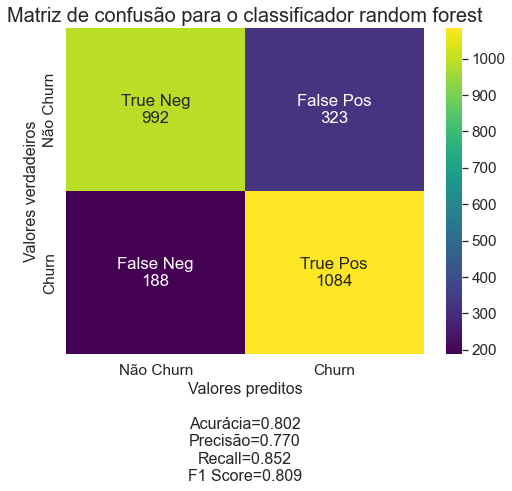

In [22]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_rf,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador random forest")

### Comparando os modelos

Após o treino e teste dos modelos **SVC**, **Decision Tree** e **Random Forest**, podemos fazer as comparações entre os resultado obtidos para descobrir o melhor modelo.

Para isso, coletamos as métricas de classificação dos três dos modelos agrupamos em uma tabela de comparação.

In [23]:
modelos = ['svc', 'decision tree', 'random forest']
y_pred_treinos = [svc.predict(X_treino), dtree.predict(X_treino), rforest.predict(X_treino)]
y_pred_testes = [y_pred_svc, y_pred_dt, y_pred_rf]  

In [24]:
tabelo_modelos = compara_modelos_metricas('Recall', modelos, y_treino, y_pred_treinos, y_teste, y_pred_testes)
tabelo_modelos

,Modelo,Acurácia Treino,Acurácia Teste,Precisão,Recall,F1-Score
0,random forest,0.811622,0.802474,0.770434,0.852201,0.809257
1,decision tree,0.814586,0.804407,0.776335,0.845912,0.809631
2,svc,0.751836,0.750676,0.733086,0.775157,0.753535
